# Cognitive Science : Q Learning
## Q2 : Frozen Lake
### Importing Basic Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output as clr
%matplotlib inline

### Defining Lake

In [2]:
class frozen_lake:
    
    def __init__(self, N, M):
        
        self.num_holes = M
        self.dimension = N
        self.n_states = N*N
        self.n_actions = 4
        self.action_set = ['L','R','U','D']
        self.action_set_map = [0,1,2,3]
        self.grid = np.zeros((N,N))
        self.holes = np.random.choice(N*N-4, M, replace = False)
        self.corners = [[0,0],[0,N-1],[N-1,0],[N-1,N-1]]
        self.ends = np.random.choice([0,1,2,3], 2, replace = False)
        self.initialize_grid()
        self.end = self.corners[self.ends[1]]
        self.start = self.corners[self.ends[0]]
    
    def initialize_grid(self):
        
        N = self.dimension
        subgrid = np.zeros((N*N-4))
        for n in self.holes:
            subgrid[n] = -100
            
        
        self.grid[0,1:N-1] = subgrid[0:N-2]
        s = N-2
        for i in range(1,N-1):
            self.grid[i,:] = subgrid[s:s+N]
            s = s+N
        self.grid[N-1,1:N-1] = subgrid[s:]
        
        end = self.corners[self.ends[1]]
        self.grid[end[0],end[1]] = 100
        end = self.corners[self.ends[0]]
        self.grid[end[0],end[1]] = 0
        
        self.grid = self.grid.T
    
    def print_grid(self, grid, c_loc = None, ax = None):
        flag = True
        if(ax is None):
            fig, ax = plt.subplots(1,1)
            flag = False
            
        N = self.dimension
        
        ax.imshow(grid, cmap = 'gray')
        ax.text(self.start[0], self.start[1], 'S', bbox=dict(facecolor='blue', 
                                                    alpha=0.5
                                                    ), fontsize = int(18*6/N), horizontalalignment='center',verticalalignment='center')
        
        ax.text(self.end[0], self.end[1], 'F', bbox=dict(facecolor='green', 
                                                    alpha=0.5
                                                    ), fontsize = int(18*6/N), horizontalalignment='center',verticalalignment='center')
        
        if(c_loc is not None):
            ax.text(c_loc[0], c_loc[1], ':)', bbox=dict(facecolor='w', 
                                                    alpha=0.5
                                                    ), fontsize = int(18*6/N), horizontalalignment='center',verticalalignment='center')
        
            
        
        ax.grid(color='k', linestyle='-', linewidth=2)
        ax.set_xticks(np.arange(-.5, N+0.5, 1))
        ax.set_yticks(np.arange(-.5, N+0.5, 1))
        if(not flag):
            plt.show()
        else:
            return ax
        
    def get_possible_actions(self, pos):
        N = self.dimension
        x = pos[0]
        y = pos[1]
        ## action set = ['L', 'R', 'U', 'D']
        p_acts = [0,1,2,3]
        if(x == 0):
            p_acts.remove(0)
        elif(x == N-1):
            p_acts.remove(1)
        if(y == 0):
            p_acts.remove(2)
        elif(y == N-1):
            p_acts.remove(3)
        return p_acts

    def get_next_pos(self, pos, move):
        p_acts = self.get_possible_actions(pos)
        if(move in p_acts):
            if(move == 0):
                pos[0] -= 1
            elif(move == 1):
                pos[0] += 1
            elif(move == 2):
                pos[1] -= 1
            else: 
                pos[1] += 1
            return pos
        else:
            return None

### Defining Q_Learning Agent

In [3]:
class lake_agent:
    
    def __init__(self, lake):

        self.lake = lake
        self.pos = self.lake.start.copy()
        self.QA_mat = np.zeros((lake.n_states, lake.n_actions))
        self.actions = self.lake.action_set
        self.dimension = self.lake.dimension
        
    def step(self,move):
        if(move == 'L'):
            act = 0
        elif(move == 'R'):
            act = 1
        elif(move == 'U'):
            act = 2
        else:
            act = 3
        pos = self.lake.get_next_pos(self.pos,  act)
        if(pos is not None):
            self.pos = pos
            
        
    def get_action(self,state, epsilon = 0.3):
        
        prob =  self.QA_mat[state,:]
        prob = np.exp(prob)+10e-12
        prob = prob/(np.sum(prob))
        
        action = np.random.choice([0,1,2,3], p = prob)
        val = np.random.rand()
        if(val < epsilon):
            action = np.random.choice([0,1,2,3])
        
        return action

    def run_episode(self, alpha = 0.3, lamda = 0.99, epsilon = 0.3, plot = False):
        
        self.pos = self.lake.start.copy()
        net_reward = 0
        
        while(self.pos != self.lake.end):
            
            state = self.pos[0]*self.dimension + self.pos[1]
            action = self.get_action(state, epsilon = epsilon)
            reward = 0
            possible_actions = self.lake.get_possible_actions(self.pos)
            
            if(action in possible_actions):
                
                curr_qa = self.QA_mat[state,action]
                
                
                self.step(self.actions[action])
                
                reward = self.lake.grid.T[self.pos[0], self.pos[1]]
                net_reward+=reward
                
                new_state = self.pos[0]*self.dimension + self.pos[1]
                new_qa_max = np.max(self.QA_mat[new_state,:])
                
                
                self.QA_mat[state,action] = (1-alpha)*curr_qa + alpha*(reward + lamda*new_qa_max)
            
            if(plot):
                fig, ax = plt.subplots(1,2, figsize = [10,5])
                clr(wait = True)
                ax[0] = self.lake.print_grid(self.lake.grid, self.pos, ax = ax[0])
                ax[1] = self.lake.print_grid(np.max(self.QA_mat, axis = 1).reshape(-1,self.dimension).T, self.pos, ax = ax[1])
                
                ax[0].set_title('Construction')
                ax[1].set_title('Max Q values')
                plt.show()
                
        return net_reward

In [4]:
def plot_directions(QA_mat, map_action):
    a,b = QA_mat.shape
    d = int(np.sqrt(a))
    mat = np.zeros((d,d))
    max_i = map_action[np.argmax(QA_mat, axis = 1)]
            
    return max_i.reshape(d,d)

### Making the model work ...

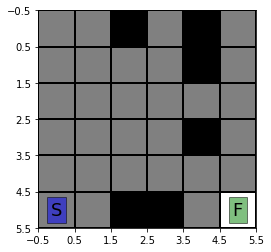

In [23]:
# defining lake
lake = frozen_lake(6,6)
lake.print_grid(lake.grid)

In [24]:
## defining agent
agent = lake_agent(lake)

In [25]:
## Epsilon greedy exploration

eps = 0.9 # exploration parameter
pplt = False # plot variable
his = []
epochs = 300 # number of epochs
for episode in range(epochs):
    clr(wait = True)
    print("Epsilon :" , eps, ", Remaining epochs :", epochs - episode - 1)
    ret = agent.run_episode(alpha = 0.8, lamda =0.9 , epsilon=eps, plot = pplt)
    his.append(ret)
    eps = 0.9*eps
    if(eps < 0.01):
        eps = 0.3

Epsilon : 0.021536939630755585 , Remaining epochs : 0


### Visualizing learned agent play and Max Q values

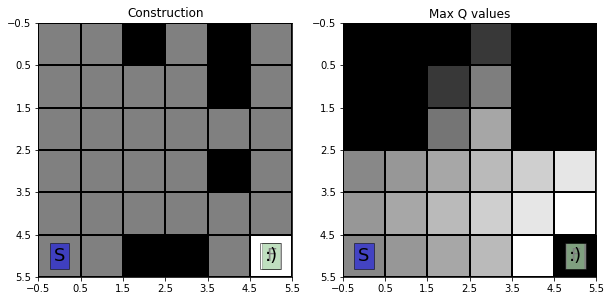

In [26]:
nrew = agent.run_episode(alpha = 0 , epsilon=0.1, plot = True)

#### Visulaizing Optimal Directions Obtained

In [27]:
mats = plot_directions(agent.QA_mat,np.array([u"\u2190",u"\u2192",u"\u2191",u"\u2193"]))
print('Max Q value directions\n')
print(mats.T)

Max Q value directions

[['←' '←' '←' '↓' '←' '→']
 ['←' '←' '→' '↓' '←' '→']
 ['←' '←' '→' '↓' '←' '←']
 ['↓' '→' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '↓']
 ['→' '↑' '↑' '↑' '→' '←']]


## Observations

### (a). Reward vs Number of episodes

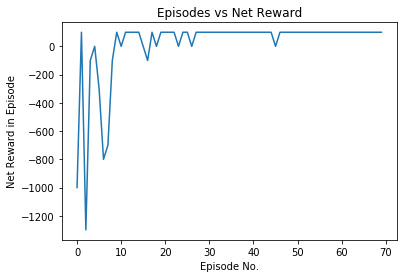

In [28]:
plt.plot(his[:70])
plt.title('Episodes vs Net Reward')
plt.xlabel('Episode No.')
plt.ylabel('Net Reward in Episode')
plt.savefig("08.png")
plt.show()

#### we see that the net reward per episode increases with time so our problem is getting converged and working properly.

### (b). Convergence with alpha and lambda

Alpha : 0.8000000000000002 , Epsilon : 0.10460353203000003 , Remaining epochs : 0


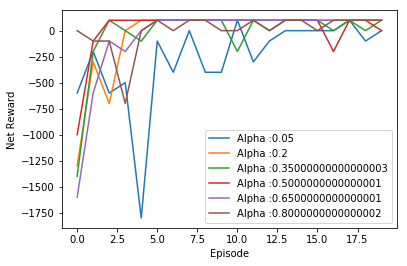

In [29]:
eps = 0.9
pplt = False
hiss = []
epochs = 20
alphas = np.arange(0.05,0.81,0.15)
for alpha in alphas:
    agent = lake_agent(lake)
    his = []
    for episode in range(epochs):
        clr(wait = True)
        print("Alpha :",alpha,", Epsilon :" , eps, ", Remaining epochs :", epochs - episode - 1)
        ret = agent.run_episode(alpha = alpha , epsilon=eps, plot = pplt)
        his.append(ret)
        eps = 0.9*eps
        if(eps < 0.01):
            eps = 0.3
    plt.plot(his, label = "Alpha :" +str(alpha))
plt.legend()
plt.xlabel('Episode')
plt.ylabel("Net Reward")
plt.savefig("09.png")
plt.show()

lamdas : 0.8000000000000002 , Epsilon : 0.10460353203000003 , Remaining epochs : 0


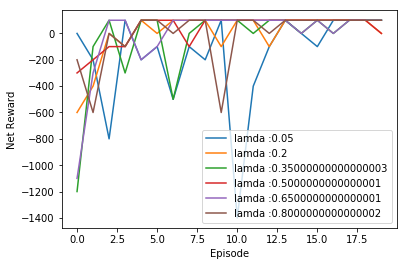

In [30]:
eps = 0.9
pplt = False
hiss = []
epochs = 20
lamdas = np.arange(0.05,0.81,0.15)
for lamda in lamdas:
    agent = lake_agent(lake)
    his = []
    for episode in range(epochs):
        clr(wait = True)
        print("lamdas :",lamda,", Epsilon :" , eps, ", Remaining epochs :", epochs - episode - 1)
        ret = agent.run_episode(lamda = lamda , epsilon=eps, plot = pplt)
        his.append(ret)
        eps = 0.9*eps
        if(eps < 0.01):
            eps = 0.3
    plt.plot(his, label = "lamda :" +str(lamda))
plt.legend()
plt.xlabel('Episode')
plt.ylabel("Net Reward")
plt.savefig("10.png")
plt.show()

#### we see that the with higher alpha value the agent learns faster. Similarily with higher lambda values the agent learns faster and the Q table converges faster.

### (c). Effect of Grid Size N and Number of holes M

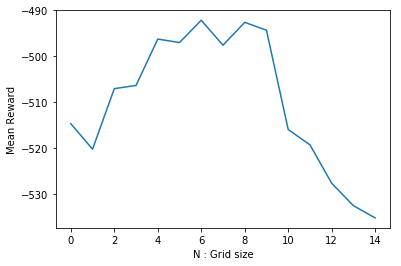

In [33]:
epochs = 15
m = 4
mean_rews = []
for n in np.arange(3,18,1):
        eps = 0.9
        lake = frozen_lake(n,m)
        agent = lake_agent(lake)
        for episode in range(epochs):
            ret = agent.run_episode(lamda = lamda , epsilon=eps, plot = pplt)
            his.append(ret)
            eps = 0.9*eps
            if(eps < 0.01):
                eps = 0.3
            
        mean_rew = np.mean(his)
        mean_rews.append(mean_rew)

plt.plot(mean_rews)
plt.xlabel('N : Grid size')
plt.ylabel("Mean Reward")
plt.savefig("11.png")
plt.show()

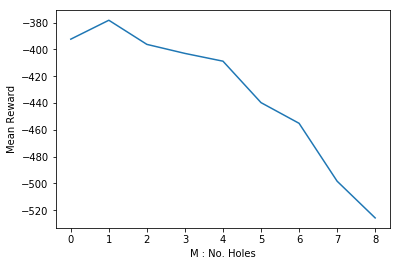

In [32]:
epochs = 15
n = 10
mean_rews = []
for m in np.arange(3,12,1):
        eps = 0.9
        lake = frozen_lake(n,m)
        agent = lake_agent(lake)
        for episode in range(epochs):
            ret = agent.run_episode(lamda = lamda , epsilon=eps, plot = pplt)
            his.append(ret)
            eps = 0.9*eps
            if(eps < 0.01):
                eps = 0.3
            
        mean_rew = np.mean(his)
        mean_rews.append(mean_rew)

plt.plot(mean_rews)
plt.xlabel('M : No. Holes')
plt.ylabel("Mean Reward")
plt.savefig("12.png")
plt.show()

We can observe that with increase in grid size with fixed number of holes the mean reward increases then decreases as convergence become slower due to large number of cells and as the number of holes increase the mean reward decreases as out agent is encountering more number of holes and is converging slowly.

### Thankyou
Abhishek Kumar

18111002